# Comparison extended percentile - U-Net approach

In [1]:
# import modules

# basics
import os, glob, sys
import warnings
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import geopandas as gp

# # fitting
from scipy import signal
from scipy.stats import iqr
import matplotlib.pylab

# cubic spline
from scipy.interpolate import LSQUnivariateSpline

## DEM approach

In [2]:
# load WGS 84 gdf
gdf = gp.read_file(f'../data/beams/SGM/SAF_20220901_DEMs_GT3R_intp.shp')

In [3]:
# get alongtrack and photon elevation
xz = gdf[['alongtrack', 'PhH_navd88']].to_numpy()

In [4]:
# ground photon indices from percentile approach
ind_PA = np.load('../data/ground/Perc/Percentile_GP_index.npy')
print(len(ind_PA))
# non-ground photons
not_ind_PA = np.setxor1d(np.arange(len(gdf)), ind_PA)

58237


In [5]:
# ground photon indices from machine learning/U-Net approach
ind_ML = np.load('../data/ground/ML/ground_ML_new.npy')
print(len(ind_ML))
# non-ground photons
not_ind_ML = np.setxor1d(np.arange(len(gdf)), ind_ML)

62235


In [6]:
# get ground photons
xz_PA = xz[ind_PA]
xz_ML = xz[ind_ML]
# few ML indices are scrambled --> sort
xz_ML = xz_ML[xz_ML[:,0].argsort()]

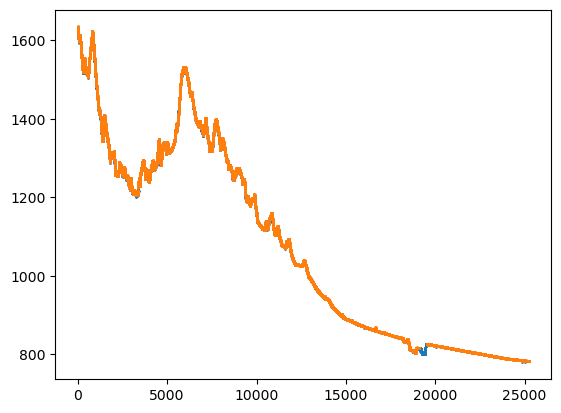

In [7]:
# show
plt.scatter(xz_PA[:,0], xz_PA[:,1], s=1)
plt.scatter(xz_ML[:,0], xz_ML[:,1], s=1);

In [7]:
# indices for landscapes
mtns = np.where(xz[:,0] < 12700)[0]
fhills = np.where((xz[:,0] >= 12700) & (xz[:,0] < 16400))[0]
plains1 = np.where((xz[:,0] >= 16400) & ((xz[:,0] < 19090)))[0]
plains2 = np.where(xz[:,0] > 19460)[0]
plains = np.concatenate((plains1, plains2))

In [8]:
# load DEM
DEM = gdf[['alongtrack', 'dem_1m_nav']].to_numpy()

In [9]:
# subset xz and DEM to landscapes
DEM_mtns = DEM[mtns]
xz_mtns = xz[mtns]

DEM_fhills = DEM[fhills]
xz_fhills = xz[fhills]

DEM_plains = DEM[plains]
xz_plains = xz[plains]

# gap at the quarry in the plains region, ML spline cant be calculated over it
DEM_plains1 = DEM[plains1]
xz_plains1 = xz[plains1]
DEM_plains2 = DEM[plains2]
xz_plains2 = xz[plains2]

#### PA

In [10]:
# percentile approach
# cubic spline on PA ground photons
t_PA = np.arange(xz_PA[0,0]+1, xz_PA[-1,0]-1, 7).tolist()
spl_PA = LSQUnivariateSpline(xz_PA[:,0], xz_PA[:,1], t_PA)

Median diff = 0.19 m
RMSE = 1.19 m
MdSE = 0.506 m²
IQR = 1.37 m


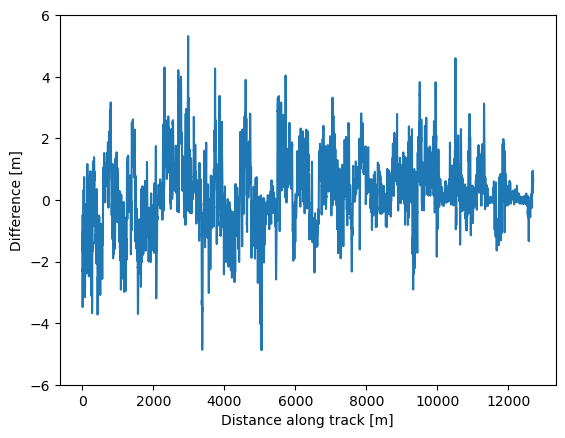

In [28]:
# calculate and plot difference between DEM and spline - mountains
diff_PA_mtns = DEM_mtns[:,1] - spl_PA(xz_mtns[:,0])
plt.plot(xz_mtns[:,0],diff_PA_mtns);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.nanmedian((diff_PA_mtns)):.2f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_PA_mtns)**2)):.2f} m')
print(f'MdSE = {np.nanmedian((diff_PA_mtns)**2):.3f} m²')
print(f'IQR = {iqr(diff_PA_mtns):.2f} m')

Median diff = -0.04 m
RMSE = 0.33 m
MdSE = 0.010 m²
IQR = 0.19 m


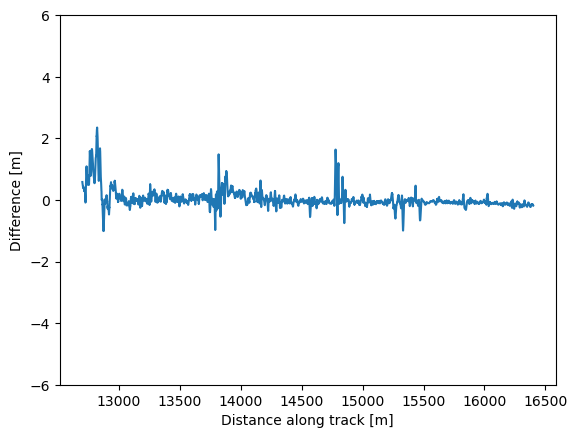

In [29]:
# calculate and plot difference between DEM and spline - foothills
diff_PA_fhills = DEM_fhills[:,1] - spl_PA(xz_fhills[:,0])
plt.plot(xz_fhills[:,0],diff_PA_fhills);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.nanmedian((diff_PA_fhills)):.2f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_PA_fhills)**2)):.2f} m')
print(f'MdSE = {np.nanmedian((diff_PA_fhills)**2):.3f} m²')
print(f'IQR = {iqr(diff_PA_fhills):.2f} m')

Median diff = -0.13 m
RMSE = 0.38 m
MdSE = 0.021 m²
IQR = 0.12 m


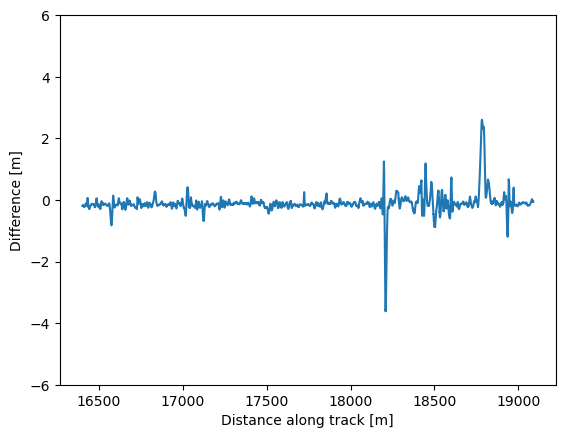

In [30]:
# calculate and plot difference between DEM and spline - plains (before quarry)
diff_PA_plains1 = DEM_plains1[:,1] - spl_PA(xz_plains1[:,0])
plt.plot(xz_plains1[:,0],diff_PA_plains1);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.nanmedian((diff_PA_plains1)):.2f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_PA_plains1)**2)):.2f} m')
print(f'MdSE = {np.nanmedian((diff_PA_plains1)**2):.3f} m²')
print(f'IQR = {iqr(diff_PA_plains1):.2f} m')

Median diff = 0.17 m
RMSE = 0.22 m
MdSE = 0.036 m²
IQR = 0.22 m


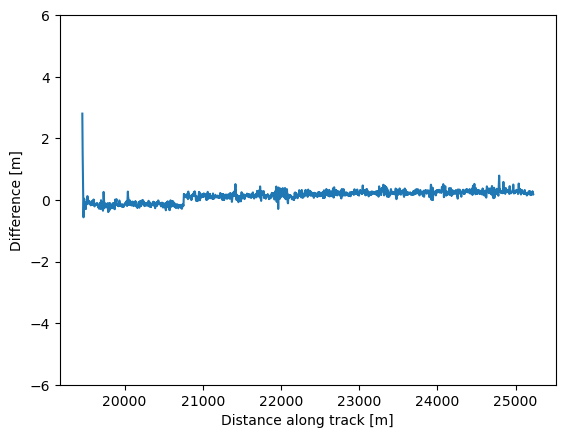

In [31]:
# calculate and plot difference between DEM and spline - plains (after quarry)
diff_PA_plains2 = DEM_plains2[:,1] - spl_PA(xz_plains2[:,0])
plt.plot(xz_plains2[:,0],diff_PA_plains2);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.nanmedian((diff_PA_plains2)):.2f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_PA_plains2)**2)):.2f} m')
print(f'MdSE = {np.nanmedian((diff_PA_plains2)**2):.3f} m²')
print(f'IQR = {iqr(diff_PA_plains2):.2f} m')

In [32]:
# combining both subsets
diff_PA_plains = np.concatenate((diff_PA_plains1,diff_PA_plains2))
print(f'Median diff = {np.nanmedian((diff_PA_plains)):.2f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_PA_plains)**2)):.2f} m')
print(f'MdSE = {np.nanmedian((diff_PA_plains)**2):.3f} m²')
print(f'IQR = {iqr(diff_PA_plains):.2f} m')

Median diff = 0.10 m
RMSE = 0.28 m
MdSE = 0.031 m²
IQR = 0.35 m


In [33]:
# all
diff_PA = np.concatenate((diff_PA_mtns, diff_PA_fhills, diff_PA_plains1,diff_PA_plains2))
print(f'Median diff = {np.nanmedian((diff_PA)):.2f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_PA)**2)):.2f} m')
print(f'MdSE = {np.nanmedian((diff_PA)**2):.3f} m²')
print(f'IQR = {iqr(diff_PA):.2f} m')

Median diff = 0.08 m
RMSE = 0.88 m
MdSE = 0.064 m²
IQR = 0.51 m


#### ML

In [18]:
# ML approach
# cubic splines on ML ground photons - have to be split because of the gap in ground photons

t_k = 7
# filtering before the quarry
xz_ML1 = xz_ML[np.where(xz_ML[:,0] < 19090)[0]]
t_ML1 = np.arange(xz_ML1[0,0]+1, xz_ML1[-1,0]-1, t_k).tolist()
spl_ML1 = LSQUnivariateSpline(xz_ML1[:,0], xz_ML1[:,1], t_ML1)

# filtering after the quarry
xz_ML2 = xz_ML[np.where(xz_ML[:,0] > 19460)[0]]
t_ML2 = np.arange(xz_ML2[0,0]+1, xz_ML2[-1,0]-1, t_k).tolist()
spl_ML2 = LSQUnivariateSpline(xz_ML2[:,0], xz_ML2[:,1], t_ML2)

Median diff = -0.083 m
RMSE = 1.221 m
MdSE = 0.499 m²
IQR = 1.446 m


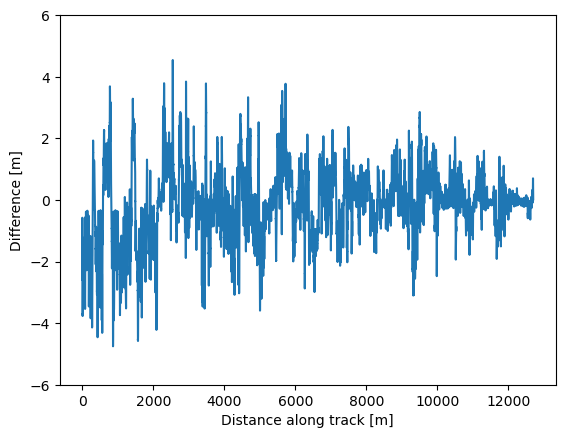

In [19]:
# calculate and plot difference between DEM and spline - mountains
diff_ML_mtns = DEM_mtns[:,1] - spl_ML1(xz_mtns[:,0])
plt.plot(xz_mtns[:,0],diff_ML_mtns);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.median(diff_ML_mtns):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML_mtns)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML_mtns)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML_mtns):.3f} m')

Median diff = -0.098 m
RMSE = 0.408 m
MdSE = 0.016 m²
IQR = 0.151 m


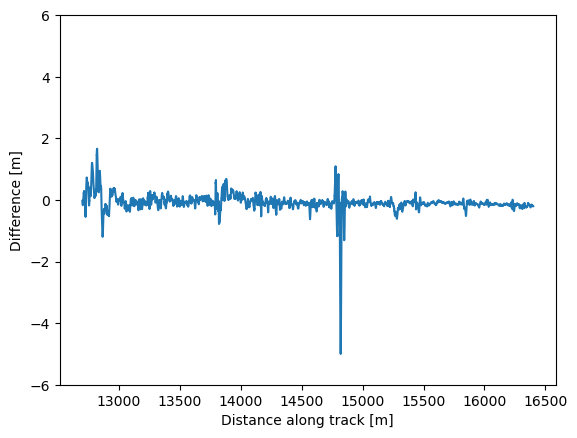

In [20]:
# calculate and plot difference between DEM and spline - foothills
diff_ML_fhills = DEM_fhills[:,1] - spl_ML1(xz_fhills[:,0])
plt.plot(xz_fhills[:,0],diff_ML_fhills);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.median(diff_ML_fhills):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML_fhills)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML_fhills)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML_fhills):.3f} m')

Median diff = -0.172 m
RMSE = 0.420 m
MdSE = 0.032 m²
IQR = 0.116 m


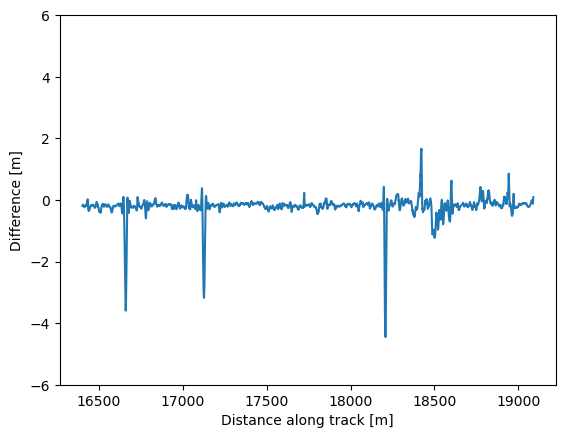

In [21]:
# calculate and plot difference between DEM and spline - plains (before quarry)
diff_ML_plains1 = DEM_plains1[:,1] - spl_ML1(xz_plains1[:,0])
plt.plot(xz_plains1[:,0],diff_ML_plains1);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.median(diff_ML_plains1):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML_plains1)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML_plains1)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML_plains1):.3f} m')

Median diff = 0.120 m
RMSE = 4295.630 m
MdSE = 0.029 m²
IQR = 0.236 m
After outlier removal:
Median diff = 0.118 m
RMSE = 0.553 m
MdSE = 0.029 m²
IQR = 0.237 m


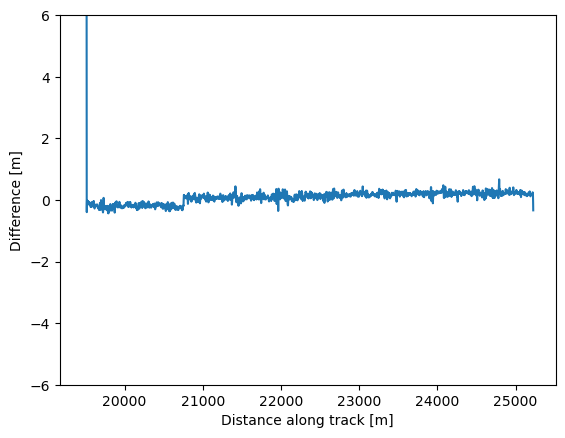

In [23]:
# calculate and plot difference between DEM and spline - plains (after quarry)
diff_ML_plains2 = DEM_plains2[:,1] - spl_ML2(xz_plains2[:,0])
plt.plot(xz_plains2[:,0],diff_ML_plains2);
plt.ylim(-6,6);
plt.ylabel('Difference [m]')
plt.xlabel('Distance along track [m]')

print(f'Median diff = {np.median(diff_ML_plains2):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML_plains2)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML_plains2)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML_plains2):.3f} m')

# spline difference very high at beginning ---> outlier removal?
print('After outlier removal:')
diff_ML22 = diff_ML_plains2[np.where(diff_ML_plains2 < 50)]
print(f'Median diff = {np.median(diff_ML22):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML22)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML22)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML22):.3f} m')

In [26]:
# combining both subsets
diff_ML_plains = np.concatenate((diff_ML_plains1,diff_ML22))
print(f'Median diff = {np.median(diff_ML_plains):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML_plains)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML_plains)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML_plains):.3f} m')

Median diff = 0.033 m
RMSE = 0.517 m
MdSE = 0.030 m²
IQR = 0.346 m


In [27]:
# all
diff_ML = np.concatenate((diff_ML_mtns, diff_ML_fhills, diff_ML_plains1,diff_ML22))
print(f'Median diff = {np.median(diff_ML):.3f} m')
print(f'RMSE = {np.sqrt(np.nanmean((diff_ML)**2)):.3f} m')
print(f'MdSE = {np.nanmedian((diff_ML)**2):.3f} m²')
print(f'IQR = {iqr(diff_ML):.3f} m')

Median diff = -0.060 m
RMSE = 0.945 m
MdSE = 0.057 m²
IQR = 0.487 m


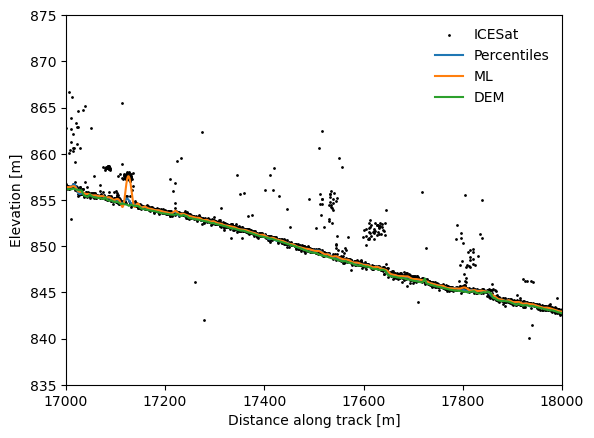

In [66]:

plt.scatter(xz[:,0], xz[:,1], s=1, c='k', label='ICESat')
plt.plot(xz_plains1[:,0], spl_PA(xz_plains1[:,0]), label='Percentiles')
plt.plot(xz_plains1[:,0], spl_ML1(xz_plains1[:,0]), c='tab:orange', label='ML');
plt.plot(DEM_plains1[:,0], DEM_plains1[:,1], c='tab:green', label='DEM');

plt.legend(frameon=False);

plt.xlim(17000,18000);
plt.ylim(835,875);
plt.ylabel('Elevation [m]')
plt.xlabel('Distance along track [m]');

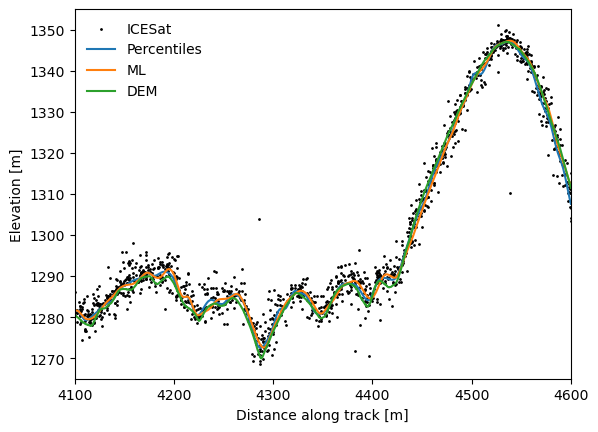

In [67]:
plt.scatter(xz[:,0], xz[:,1], s=1, c='k', label='ICESat')
plt.plot(xz_mtns[:,0], spl_PA(xz_mtns[:,0]), label='Percentiles')
plt.plot(xz_mtns[:,0], spl_ML1(xz_mtns[:,0]), c='tab:orange', label='ML');
plt.plot(DEM_mtns[:,0], DEM_mtns[:,1], c='tab:green', label='DEM');

plt.legend(frameon=False);

plt.xlim(4100,4600);
plt.ylim(1265,1355);
plt.ylabel('Elevation [m]')
plt.xlabel('Distance along track [m]');

## envelope approach

In [6]:
# ALS ground data is projected to 2D and the upper and lower bounds are used as an envelope

# load in ALS data

sys.path.append('my_functions')
from alongtrack_test import *

# load as df
ground_laz = pd.read_hdf('../data/pointclouds/SAF_20220901_GT3R_7m_dissolved_noiseHAG_nn_df.hdf')
# flip so it starts at high relief like ICESat
ground_laz = ground_laz[::-1].reset_index()
# get alongtrack
ground_laz, rotation_data = get_atl_alongtrack_XYZ(ground_laz)
# set 0 of alongtrack to ICESat's alongtrack
ground_laz.alongtrack_XYZ = ground_laz.alongtrack_XYZ - ground_laz.alongtrack_XYZ.min()
# only ground photons
ground_laz = ground_laz[ground_laz.classification == 2]
print(len(ground_laz))

952491


In [7]:
# load in ICESat-2 data in EPSG:3857
gdf = gp.read_file(f'../data/beams/SGM/SAF_20220901_DEMs_GT3R_intp_utm3857.shp')

# rename columns
gdf['X'] = gdf.geometry.x.tolist()
gdf['Y'] = gdf.geometry.y.tolist()
gdf.rename(columns={"PhH_navd88": "Z"}, inplace=True)

# get alongtrack based on 3857 CRS
gdf, rotation_data = get_atl_alongtrack_XYZ(gdf)
print(len(gdf))

74749


In [51]:
gdf

,level_0,index,Latitude,Longitude,Photon_Hei,geoid_floa,dem_1m_slp,alongtrack,corr_value,Z,dem_1m_nav,geometry,X,Y,crosstrack,alongtrack_XYZ
0,65189,1465798,34.382644,-117.965616,1593.746338,-31.456400,44.144913,0.000000,-0.701662,1625.904400,1626.788796,POINT (-13131872.345 4080298.225),-1.313187e+07,4.080298e+06,0.000000e+00,0.000000
1,65190,1465797,34.382644,-117.965616,1595.324829,-31.456400,44.144913,0.003101,-0.701659,1627.482888,1626.795020,POINT (-13131872.334 4080298.229),-1.313187e+07,4.080298e+06,1.121151e-02,0.003600
2,65191,1465799,34.382644,-117.965616,1596.407104,-31.456400,44.144913,0.005226,-0.701655,1628.565159,1626.799287,POINT (-13131872.327 4080298.233),-1.313187e+07,4.080298e+06,1.889818e-02,0.006069
3,65192,1465795,34.382644,-117.965616,1602.720825,-31.456400,44.144913,0.017400,-0.701652,1634.878877,1626.824254,POINT (-13131872.283 4080298.251),-1.313187e+07,4.080298e+06,6.374158e-02,0.020193
4,65193,1465800,34.382650,-117.965617,1595.209717,-31.456400,42.367153,0.715130,-0.701648,1627.367765,1626.555063,POINT (-13131872.418 4080299.092),-1.313187e+07,4.080299e+06,9.299847e-03,0.869771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74744,144066,1544671,34.609097,-117.991834,749.839539,-32.193001,0.782531,25225.151103,-0.696683,782.729222,782.888446,POINT (-13134790.829 4110885.124),-1.313479e+07,4.110885e+06,8.033752e-05,30725.819275
74745,144067,1544675,34.609104,-117.991834,749.403809,-32.193001,0.849551,25225.867456,-0.696683,782.293492,782.883212,POINT (-13134790.917 4110885.994),-1.313479e+07,4.110886e+06,-4.921397e-03,30726.693080
74746,144068,1544676,34.609104,-117.991834,749.800659,-32.193001,0.849551,25225.868233,-0.696683,782.690343,782.883230,POINT (-13134790.915 4110885.995),-1.313479e+07,4.110886e+06,-2.122606e-03,30726.693985
74747,144069,1544674,34.609104,-117.991834,749.871033,-32.193001,0.849551,25225.868371,-0.696683,782.760717,782.883233,POINT (-13134790.914 4110885.995),-1.313479e+07,4.110886e+06,-1.626279e-03,30726.694146


In [8]:
# makde 2D arrays and sort by ATD
xz_als = ground_laz[['alongtrack_XYZ', 'Z']].to_numpy()
xz_icesat = gdf[['alongtrack_XYZ', 'Z']].to_numpy()

xz_als = xz_als[xz_als[:,0].argsort()]
xz_icesat = xz_icesat[xz_icesat[:,0].argsort()]

In [71]:
# subset PA ground and non-ground
xz_icesat_PA = xz_icesat[ind_PA]
xz_icesat_nPA = xz_icesat[not_ind_PA]

In [45]:
# subset ML ground and non-ground (and sort again)
xz_icesat_ML = xz_icesat[ind_ML]
xz_icesat_nML = xz_icesat[not_ind_ML]

xz_icesat_ML = xz_icesat_ML[xz_icesat_ML[:,0].argsort()]
xz_icesat_nML = xz_icesat_nML[xz_icesat_nML[:,0].argsort()]

### derive envelope

In [73]:
# split the track in 1 m bins (upper ATD boundary being the last photon of the PA ground PC, as it is longer than the ML one)
split_at = xz_als[:,0].searchsorted(np.arange(int(min(xz_als[:,0])), int(max(xz_icesat_PA[:,0])+2), 1))
xz_bins = np.split(xz_als, split_at)
xz_bins = xz_bins[:-1]
# for each bin, get the min/max elevation. if the bin is empty, use elevation of 25th bin before (loss of quality in high relief zones, but data has larger gaps)
max_min_envelope = np.zeros((len(xz_bins),2))
for i in range(len(xz_bins)):
        if xz_bins[i].any():
            maxz = np.max(xz_bins[i][:,1])
            minz = np.min(xz_bins[i][:,1])
            max_min_envelope[i,0] = maxz
            max_min_envelope[i,1] = minz
        else:
            maxz = np.max(xz_bins[i-25][:,1])
            minz = np.min(xz_bins[i-25][:,1])
            max_min_envelope[i,0] = maxz
            max_min_envelope[i,1] = minz

max_min_envelope = max_min_envelope[1:-1,:]

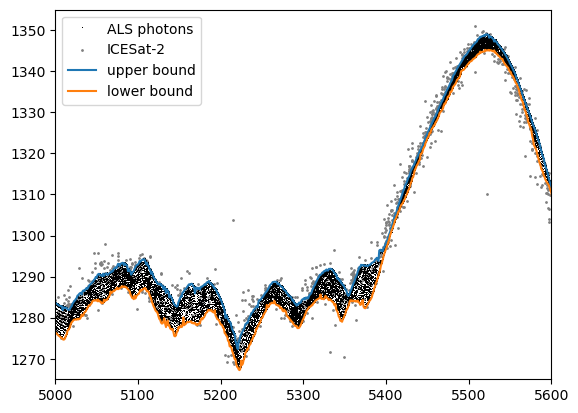

In [74]:
# plot envelope and ALS data
plt.plot(xz_als[:,0], xz_als[:,1], 'k,', label='ALS photons')
plt.scatter(xz_icesat[:,0], xz_icesat[:,1], c='grey', s=1, label='ICESat-2')
plt.plot(max_min_envelope[:,0], label='upper bound')
plt.plot(max_min_envelope[:,1], label='lower bound')
plt.legend()
plt.xlim(5000,5600);
plt.ylim(1265,1355);

###  PA

In [164]:
# envelope filter function

def envelope_filter_split(input_PC, lower, upper, max_min_envelope):
    ''' 
    Takes the defined envelope and checks if a photon within a bin is inside or outside of the envelope bounds.

    Input:
    - 2D point cloud (ATD, elevation)

    Output:
    - outside-of-envelope indices of PC (list)
    - inside-of-envelope indices of PC (list)
    '''
    split_at = input_PC[:,0].searchsorted(np.arange(lower, upper+1, 1))
    xz_bins = np.split(input_PC, split_at)
    xz_bins = xz_bins[1:-1]

    outside = []
    inside = []

    # match max_min_envelope start to "lower" value
    max_min_envelope = max_min_envelope[lower:]

    for i in range(len(xz_bins)):
        for j in range(len(xz_bins[i])):
            # if outside of quarry continue
            if (xz_bins[i][0,0] < 23250) or (xz_bins[i][0,0] > 23700):
                if xz_bins[i][j][1] > max_min_envelope[i,0]:
                    outside.append(np.sum(list(map(len, xz_bins))[:i])+j)
                if xz_bins[i][j][1] < max_min_envelope[i,1]:
                    outside.append(np.sum(list(map(len, xz_bins))[:i])+j)
                if (xz_bins[i][j][1] < max_min_envelope[i,0]) & (xz_bins[i][j][1] > max_min_envelope[i,1]):
                    inside.append(np.sum(list(map(len, xz_bins))[:i])+j)

    return [int(x) for x in outside], [int(x) for x in inside]

In [143]:
def print_metrics(TP,FP,FN,TN):
    print(f'Accuracy: {(len(TP)+len(TN))/(len(TP)+len(FP)+len(TN)+len(FN))*100:.2f} %')
    print(f'Precision: {len(TP)/(len(TP)+len(FP))*100:.2f} %')
    print(f'Sensitivity: {len(TP)/(len(TP)+len(FN))*100:.2f} %')
    print(f'Specificity: {len(TN)/(len(TN)+len(FP))*100:.2f} %')
    print(f'IoU: {len(TP)/(len(TP)+len(FP)+len(FN))*100:.2f} %')
    print(f'F1-Score: {2*len(TP)/(2*len(TP)+len(FN)+len(FP))*100:.2f} %')

#### mountains

In [276]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 0, 15500, max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nPA)}')
print(f'No of photons outside of envelope (TN): {len(outside_nPA)}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 0, 15500, max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_PA)}')
print(f'No of photons outside of envelope (FP): {len(outside_PA)}')

No of photons inside envelope (FN): 2603
No of photons outside of envelope (TN): 5338
No of photons inside envelope (TP): 20241
No of photons outside of envelope (FP): 10091


In [280]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 0, 15500, max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nPA)/np.where(xz_icesat_nPA[:,0] < 15500)[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nPA)/np.where(xz_icesat_nPA[:,0] < 15500)[0].shape[0] * 100:.2f}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 0, 15500, max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_PA)/np.where(xz_icesat_PA[:,0] < 15500)[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_PA)/np.where(xz_icesat_PA[:,0] < 15500)[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 32.78
% of photons outside of envelope (TN): 67.22
% of photons inside envelope (TP): 66.73
% of photons outside of envelope (FP): 33.27


In [150]:
print_metrics(inside_PA,outside_PA,inside_nPA,outside_nPA)

Accuracy: 66.83 %
Precision: 66.73 %
Sensitivity: 88.61 %
Specificity: 34.60 %
IoU: 61.46 %
F1-Score: 76.13 %


#### foothills

In [165]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 15500, 20000, max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nPA)}')
print(f'No of photons outside of envelope (TN): {len(outside_nPA)}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 15500, 20000, max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_PA)}')
print(f'No of photons outside of envelope (FP): {len(outside_PA)}')

No of photons inside envelope (FN): 454
No of photons outside of envelope (TN): 1781
No of photons inside envelope (TP): 3628
No of photons outside of envelope (FP): 3715


In [281]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 15500, 20000, max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nPA)/np.where((xz_icesat_nPA[:,0] >= 15500)&(xz_icesat_nPA[:,0] < 20000))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nPA)/np.where((xz_icesat_nPA[:,0] >= 15500)&(xz_icesat_nPA[:,0] < 20000))[0].shape[0] * 100:.2f}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 15500, 20000, max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_PA)/np.where((xz_icesat_PA[:,0] >= 15500)&(xz_icesat_PA[:,0] < 20000))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_PA)/np.where((xz_icesat_PA[:,0] >= 15500)&(xz_icesat_PA[:,0] < 20000))[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 20.31
% of photons outside of envelope (TN): 79.69
% of photons inside envelope (TP): 49.41
% of photons outside of envelope (FP): 50.59


In [166]:
print_metrics(inside_PA,outside_PA,inside_nPA,outside_nPA)

Accuracy: 56.47 %
Precision: 49.41 %
Sensitivity: 88.88 %
Specificity: 32.41 %
IoU: 46.53 %
F1-Score: 63.51 %


#### plains

In [174]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nPA)}')
print(f'No of photons outside of envelope (TN): {len(outside_nPA)}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_PA)}')
print(f'No of photons outside of envelope (FP): {len(outside_PA)}')

No of photons inside envelope (FN): 1388
No of photons outside of envelope (TN): 4459
No of photons inside envelope (TP): 6050
No of photons outside of envelope (FP): 13639


In [293]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nPA)/np.where((xz_icesat_nPA[:,0] >= 20000)&(xz_icesat_nPA[:,0] < 23250) | (xz_icesat_nPA[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nPA)/np.where((xz_icesat_nPA[:,0] >= 20000)&(xz_icesat_nPA[:,0] < 23250) | (xz_icesat_nPA[:,0] >= 23700))[0].shape[0] * 100:.2f}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_PA)/np.where((xz_icesat_PA[:,0] >= 20000)&(xz_icesat_PA[:,0] < 23250) | (xz_icesat_PA[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_PA)/np.where((xz_icesat_PA[:,0] >= 20000)&(xz_icesat_PA[:,0] < 23250) | (xz_icesat_PA[:,0] >= 23700))[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 23.73
% of photons outside of envelope (TN): 76.24
% of photons inside envelope (TP): 30.72
% of photons outside of envelope (FP): 69.27


In [175]:
print_metrics(inside_PA,outside_PA,inside_nPA,outside_nPA)

Accuracy: 41.15 %
Precision: 30.73 %
Sensitivity: 81.34 %
Specificity: 24.64 %
IoU: 28.70 %
F1-Score: 44.61 %


#### all

In [192]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nPA)}')
print(f'No of photons outside of envelope (TN): {len(outside_nPA)}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_PA)}')
print(f'No of photons outside of envelope (FP): {len(outside_PA)}')

No of photons inside envelope (FN): 4445
No of photons outside of envelope (TN): 11578
No of photons inside envelope (TP): 29919
No of photons outside of envelope (FP): 27445


In [301]:
# non-ground
outside_nPA, inside_nPA = envelope_filter_split(xz_icesat_nPA, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nPA)/np.where((xz_icesat_nPA[:,0] < 23250) | (xz_icesat_nPA[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nPA)/np.where((xz_icesat_nPA[:,0] < 23250) | (xz_icesat_nPA[:,0] >= 23700))[0].shape[0] * 100:.2f}')

# ground
outside_PA, inside_PA = envelope_filter_split(xz_icesat_PA, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_PA)/np.where((xz_icesat_PA[:,0] < 23250) | (xz_icesat_PA[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_PA)/np.where((xz_icesat_PA[:,0] < 23250) | (xz_icesat_PA[:,0] >= 23700))[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 27.74
% of photons outside of envelope (TN): 72.25
% of photons inside envelope (TP): 52.15
% of photons outside of envelope (FP): 47.84


In [177]:
print_metrics(inside_PA,outside_PA,inside_nPA,outside_nPA)

Accuracy: 56.55 %
Precision: 52.16 %
Sensitivity: 87.06 %
Specificity: 29.67 %
IoU: 48.41 %
F1-Score: 65.23 %


### ML

#### mountains

In [186]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 0, 15500, max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nML)}')
print(f'No of photons outside of envelope (TN): {len(outside_nML)}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 0, 15500, max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_ML)}')
print(f'No of photons outside of envelope (FP): {len(outside_ML)}')

No of photons inside envelope (FN): 853
No of photons outside of envelope (TN): 8409
No of photons inside envelope (TP): 21991
No of photons outside of envelope (FP): 7020


In [283]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 0, 15500, max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nML)/np.where(xz_icesat_nML[:,0] < 15500)[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nML)/np.where(xz_icesat_nML[:,0] < 15500)[0].shape[0] * 100:.2f}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 0, 15500, max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_ML)/np.where(xz_icesat_ML[:,0] < 15500)[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_ML)/np.where(xz_icesat_ML[:,0] < 15500)[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 9.21
% of photons outside of envelope (TN): 90.79
% of photons inside envelope (TP): 75.80
% of photons outside of envelope (FP): 24.20


In [179]:
print_metrics(inside_ML,outside_ML,inside_nML,outside_nML)

Accuracy: 79.43 %
Precision: 75.80 %
Sensitivity: 96.27 %
Specificity: 54.50 %
IoU: 73.64 %
F1-Score: 84.82 %


#### foothills

In [190]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 15500, 20000, max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nML)}')
print(f'No of photons outside of envelope (TN): {len(outside_nML)}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 15500, 20000, max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_ML)}')
print(f'No of photons outside of envelope (FP): {len(outside_ML)}')

No of photons inside envelope (FN): 28
No of photons outside of envelope (TN): 703
No of photons inside envelope (TP): 4054
No of photons outside of envelope (FP): 4793


In [284]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 15500, 20000, max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nML)/np.where((xz_icesat_nML[:,0] >= 15500)&(xz_icesat_nML[:,0] < 20000))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nML)/np.where((xz_icesat_nML[:,0] >= 15500)&(xz_icesat_nML[:,0] < 20000))[0].shape[0] * 100:.2f}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 15500, 20000, max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_ML)/np.where((xz_icesat_ML[:,0] >= 15500)&(xz_icesat_ML[:,0] < 20000))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_ML)/np.where((xz_icesat_ML[:,0] >= 15500)&(xz_icesat_ML[:,0] < 20000))[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 3.83
% of photons outside of envelope (TN): 96.17
% of photons inside envelope (TP): 45.82
% of photons outside of envelope (FP): 54.18


In [191]:
print_metrics(inside_ML,outside_ML,inside_nML,outside_nML)

Accuracy: 49.67 %
Precision: 45.82 %
Sensitivity: 99.31 %
Specificity: 12.79 %
IoU: 45.68 %
F1-Score: 62.71 %


#### plains

In [181]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nML)}')
print(f'No of photons outside of envelope (TN): {len(outside_nML)}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_ML)}')
print(f'No of photons outside of envelope (FP): {len(outside_ML)}')

No of photons inside envelope (FN): 85
No of photons outside of envelope (TN): 1074
No of photons inside envelope (TP): 7353
No of photons outside of envelope (FP): 17024


In [287]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nML)/np.where((xz_icesat_nML[:,0] >= 20000)&(xz_icesat_nML[:,0] < 23250) | (xz_icesat_nML[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nML)/np.where((xz_icesat_nML[:,0] >= 20000)&(xz_icesat_nML[:,0] < 23250) | (xz_icesat_nML[:,0] >= 23700))[0].shape[0] * 100:.2f}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 20000, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_ML)/np.where((xz_icesat_ML[:,0] >= 20000)&(xz_icesat_ML[:,0] < 23250) | (xz_icesat_ML[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_ML)/np.where((xz_icesat_ML[:,0] >= 20000)&(xz_icesat_ML[:,0] < 23250) | (xz_icesat_ML[:,0] >= 23700))[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 7.31
% of photons outside of envelope (TN): 92.35
% of photons inside envelope (TP): 30.16
% of photons outside of envelope (FP): 69.84


In [182]:
print_metrics(inside_ML,outside_ML,inside_nML,outside_nML)

Accuracy: 33.00 %
Precision: 30.16 %
Sensitivity: 98.86 %
Specificity: 5.93 %
IoU: 30.06 %
F1-Score: 46.22 %


#### all

In [300]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (FN): {len(inside_nML)}')
print(f'No of photons outside of envelope (TN): {len(outside_nML)}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'No of photons inside envelope (TP): {len(inside_ML)}')
print(f'No of photons outside of envelope (FP): {len(outside_ML)}')

No of photons inside envelope (FN): 966
No of photons outside of envelope (TN): 10186
No of photons inside envelope (TP): 33398
No of photons outside of envelope (FP): 28837


In [291]:
# non-ground
outside_nML, inside_nML = envelope_filter_split(xz_icesat_nML, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (FN): {len(inside_nML)/np.where((xz_icesat_nML[:,0] < 23250) | (xz_icesat_nML[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (TN): {len(outside_nML)/np.where((xz_icesat_nML[:,0] < 23250) | (xz_icesat_nML[:,0] >= 23700))[0].shape[0] * 100:.2f}')

# ground
outside_ML, inside_ML = envelope_filter_split(xz_icesat_ML, 0, int(xz_icesat[-1,0]), max_min_envelope)
print(f'% of photons inside envelope (TP): {len(inside_ML)/np.where((xz_icesat_ML[:,0] < 23250) | (xz_icesat_ML[:,0] >= 23700))[0].shape[0] * 100:.2f}')
print(f'% of photons outside of envelope (FP): {len(outside_ML)/np.where((xz_icesat_ML[:,0] < 23250) | (xz_icesat_ML[:,0] >= 23700))[0].shape[0] * 100:.2f}')

% of photons inside envelope (FN): 8.66
% of photons outside of envelope (TN): 91.31
% of photons inside envelope (TP): 53.66
% of photons outside of envelope (FP): 46.34


In [184]:
print_metrics(inside_ML,outside_ML,inside_nML,outside_nML)

Accuracy: 59.39 %
Precision: 53.66 %
Sensitivity: 97.19 %
Specificity: 26.10 %
IoU: 52.84 %
F1-Score: 69.15 %


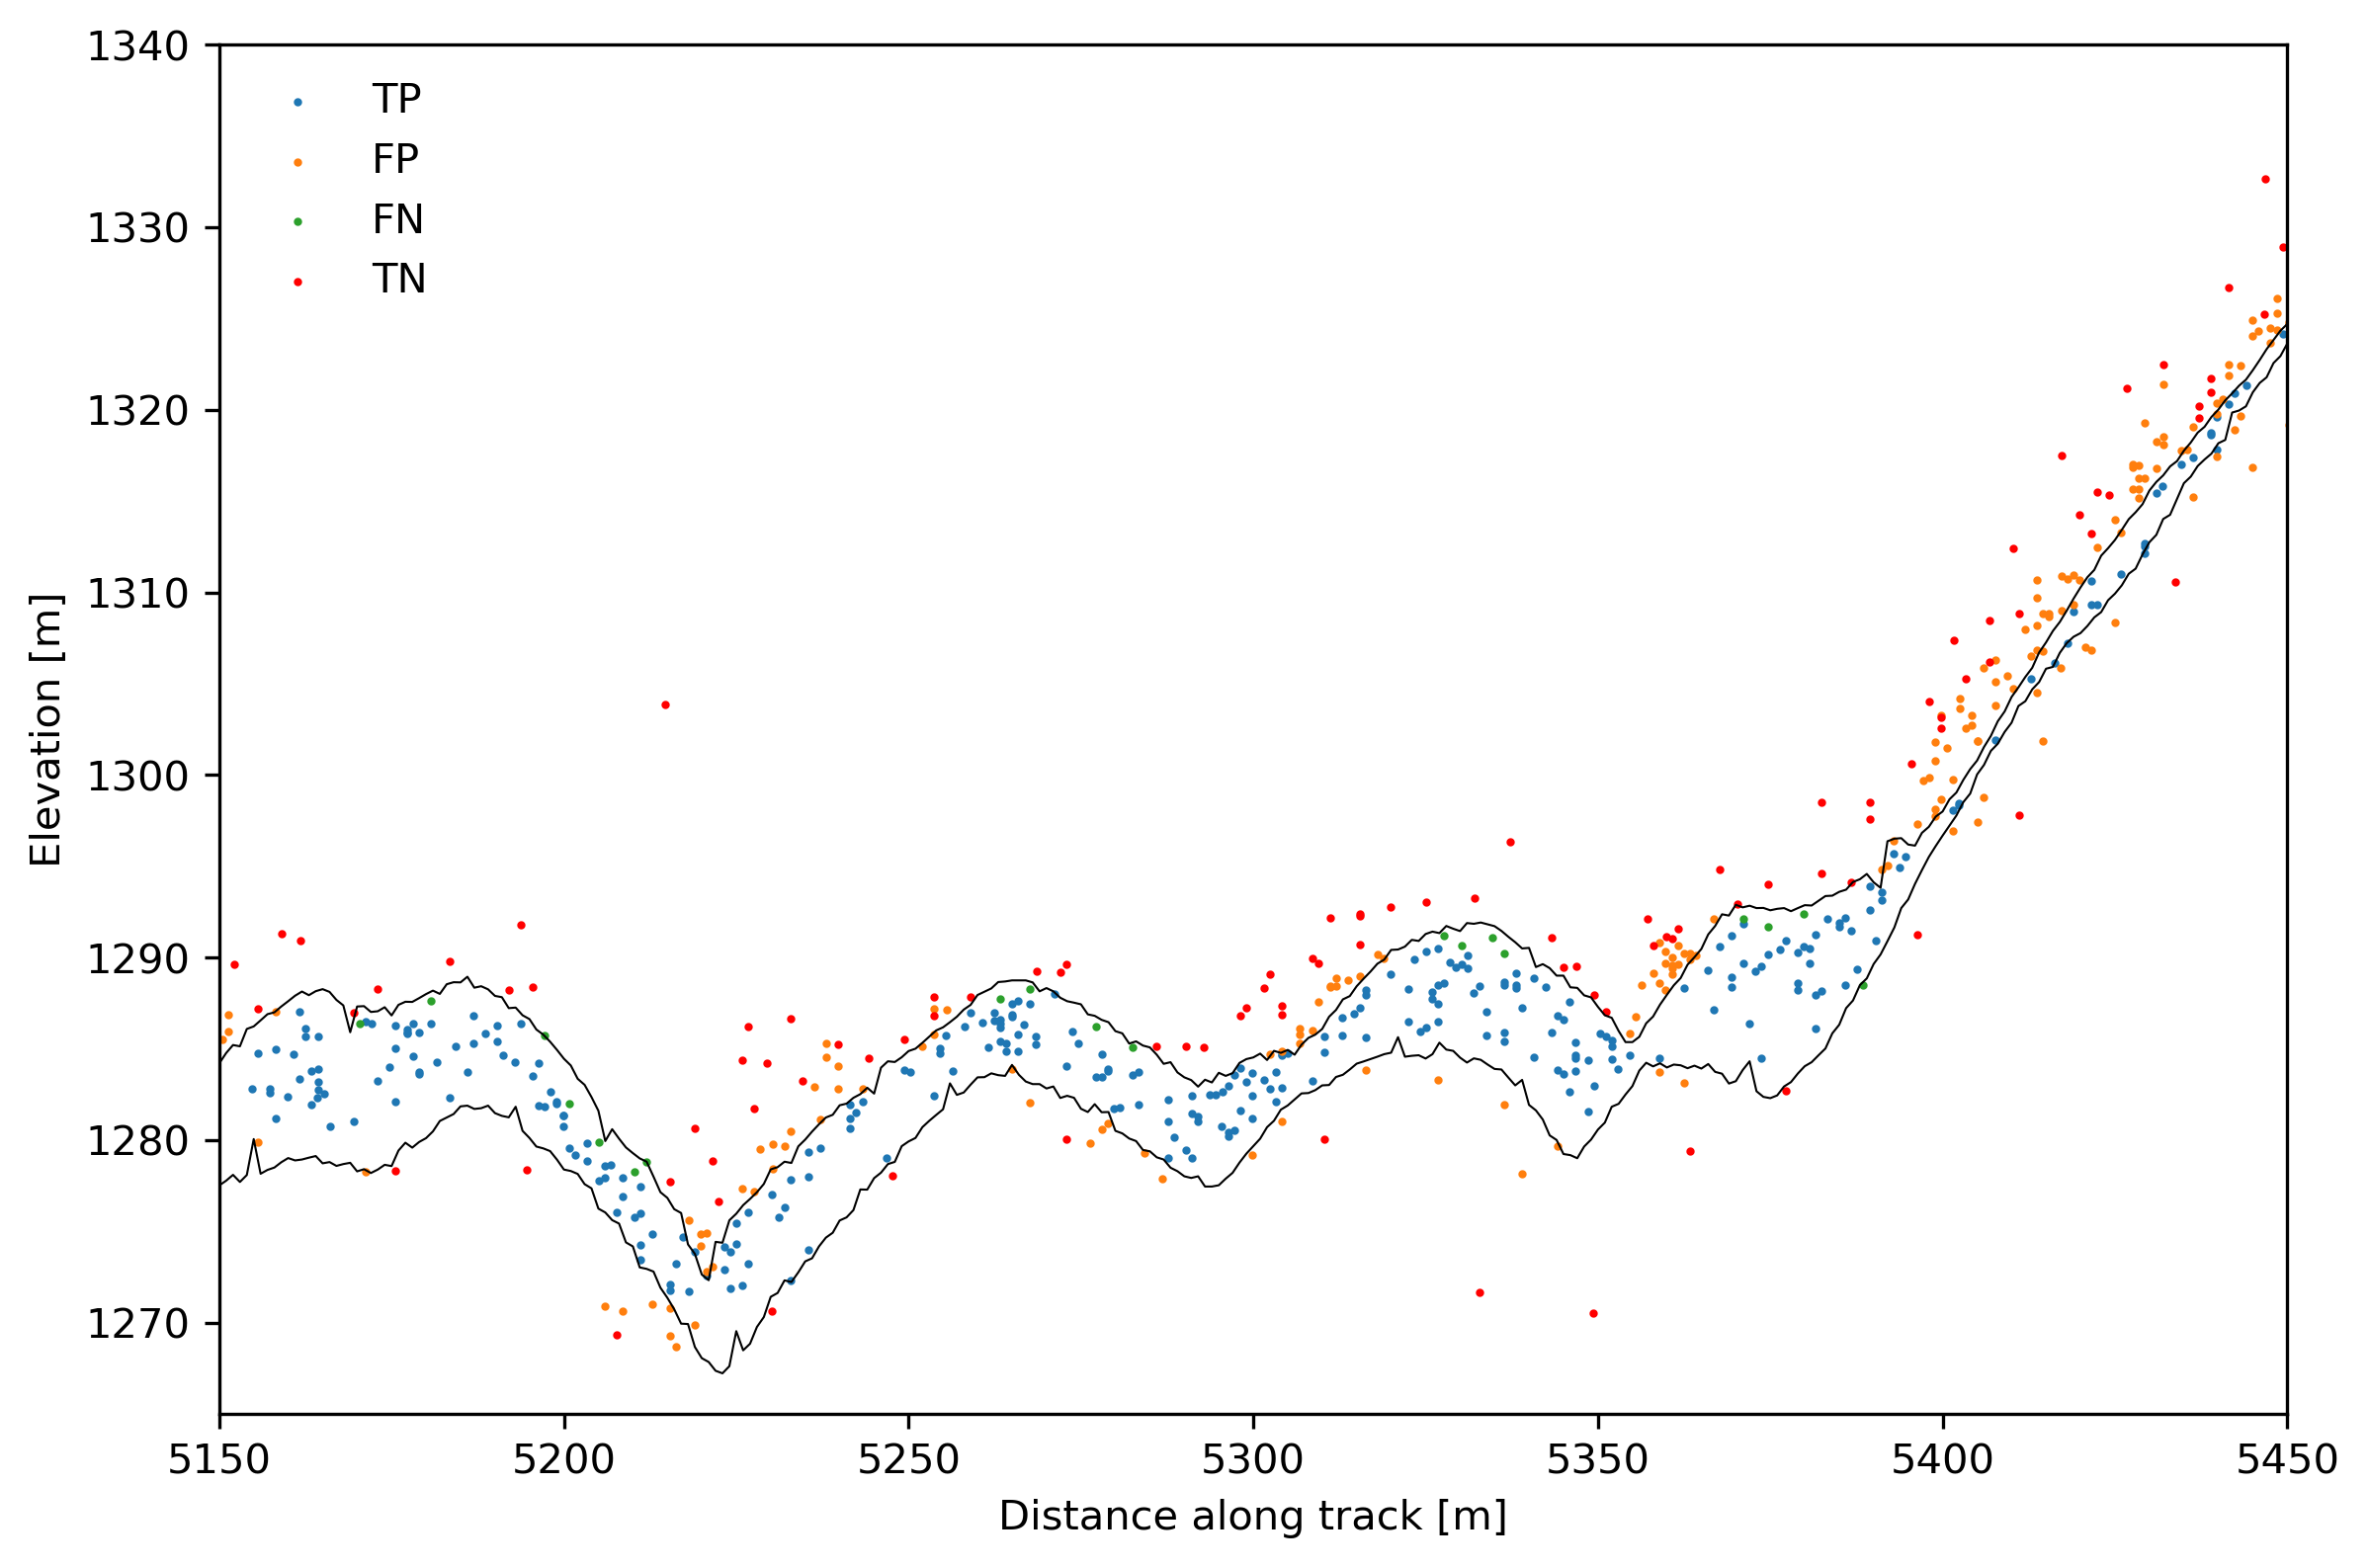

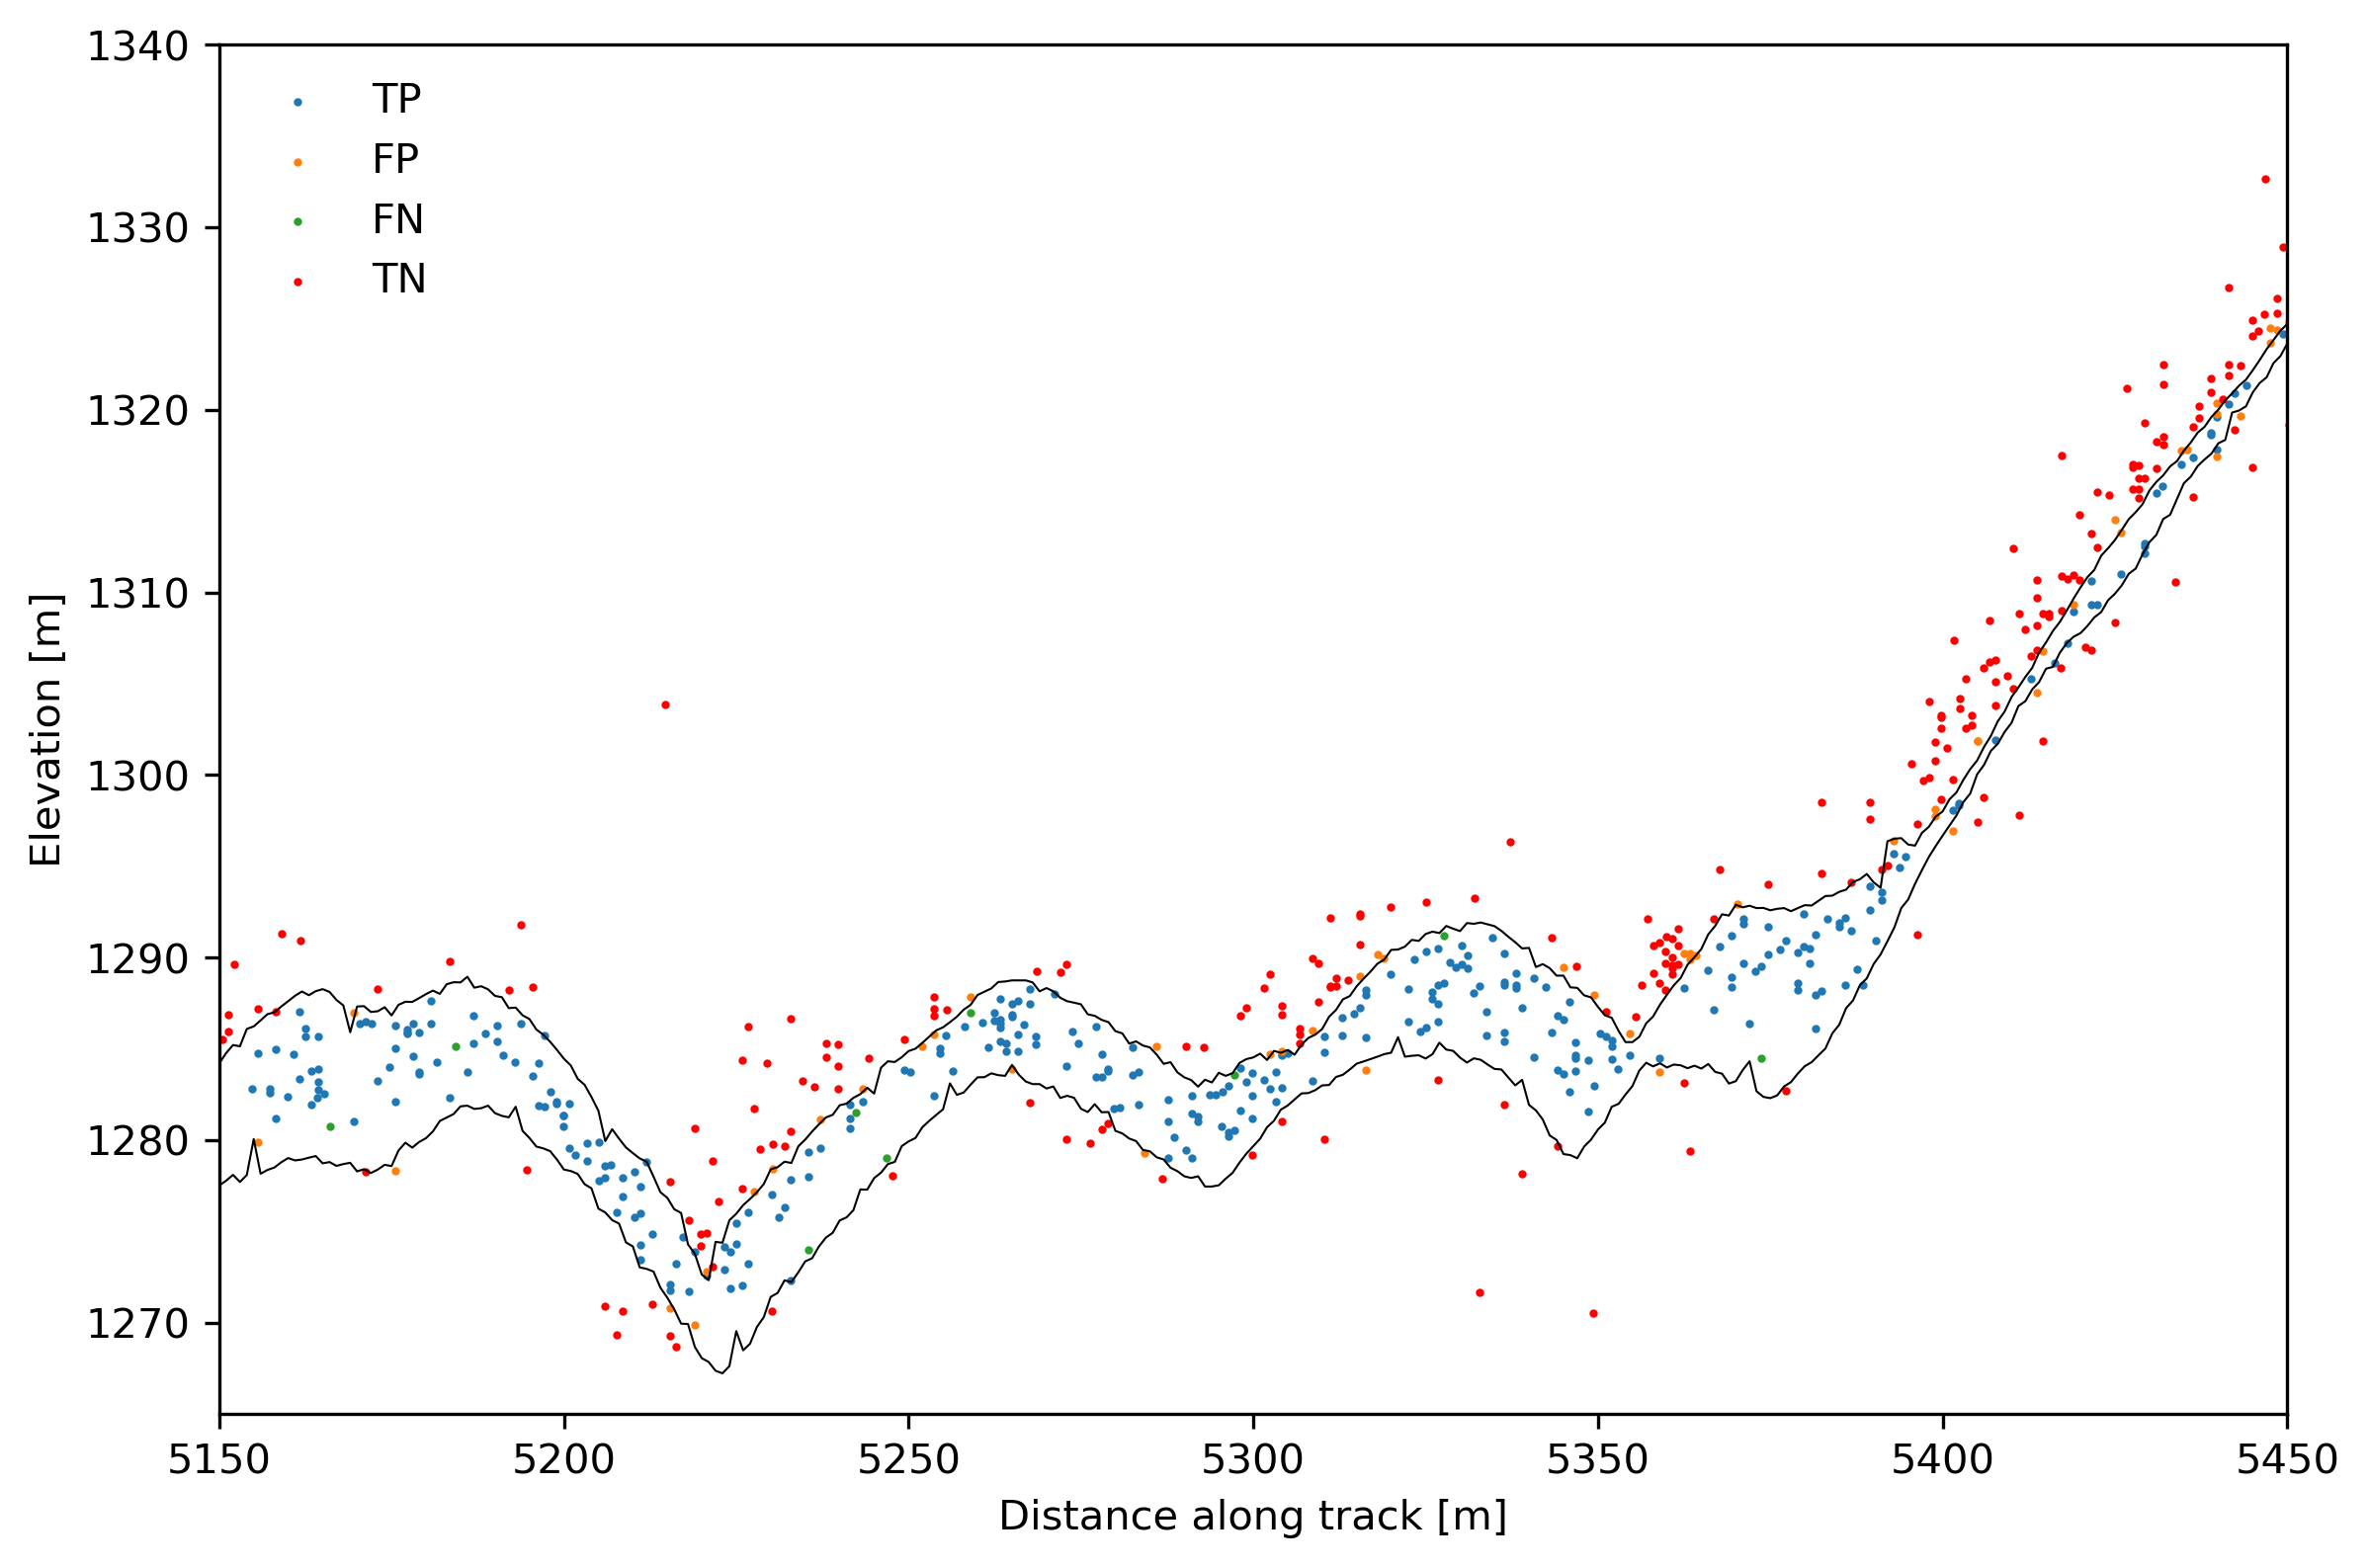

In [309]:
fig, ax = plt.subplots(figsize=(9,6))
fig.set_dpi(300)
ax.plot(max_min_envelope[:,0], c='k', lw=0.5)
ax.plot(max_min_envelope[:,1], c='k', lw=0.5)
ax.scatter(xz_icesat_PA[inside_PA,0], xz_icesat_PA[inside_PA,1], c='tab:blue', s=1, label='TP')
ax.scatter(xz_icesat_PA[outside_PA,0], xz_icesat_PA[outside_PA,1], c='tab:orange', s=1, label='FP')
ax.scatter(xz_icesat_nPA[inside_nPA,0], xz_icesat_nPA[inside_nPA,1], c='tab:green', s=1, label='FN')
ax.scatter(xz_icesat_nPA[outside_nPA,0], xz_icesat_nPA[outside_nPA,1], c='r', s=1, label='TN')
ax.legend(frameon=False)
ax.set_xlim(5150,5450);
ax.set_ylim(1265,1340);
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]')

plt.savefig('../writing/img/env_1.png', bbox_inches='tight', transparent=True)

fig, ax = plt.subplots(figsize=(9,6))
fig.set_dpi(300)
ax.plot(max_min_envelope[:,0], c='k', lw=0.5)
ax.plot(max_min_envelope[:,1], c='k', lw=0.5)
ax.scatter(xz_icesat_ML[inside_ML,0], xz_icesat_ML[inside_ML,1], c='tab:blue', s=1, label='TP')
ax.scatter(xz_icesat_ML[outside_ML,0], xz_icesat_ML[outside_ML,1], c='tab:orange', s=1, label='FP')
ax.scatter(xz_icesat_nML[inside_nML,0], xz_icesat_nML[inside_nML,1], c='tab:green', s=1, label='FN')
ax.scatter(xz_icesat_nML[outside_nML,0], xz_icesat_nML[outside_nML,1], c='r', s=1, label='TN')
ax.legend(frameon=False)
ax.set_xlim(5150,5450);
ax.set_ylim(1265,1340);
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]')

plt.savefig('../writing/img/env_2.png', bbox_inches='tight', transparent=True)

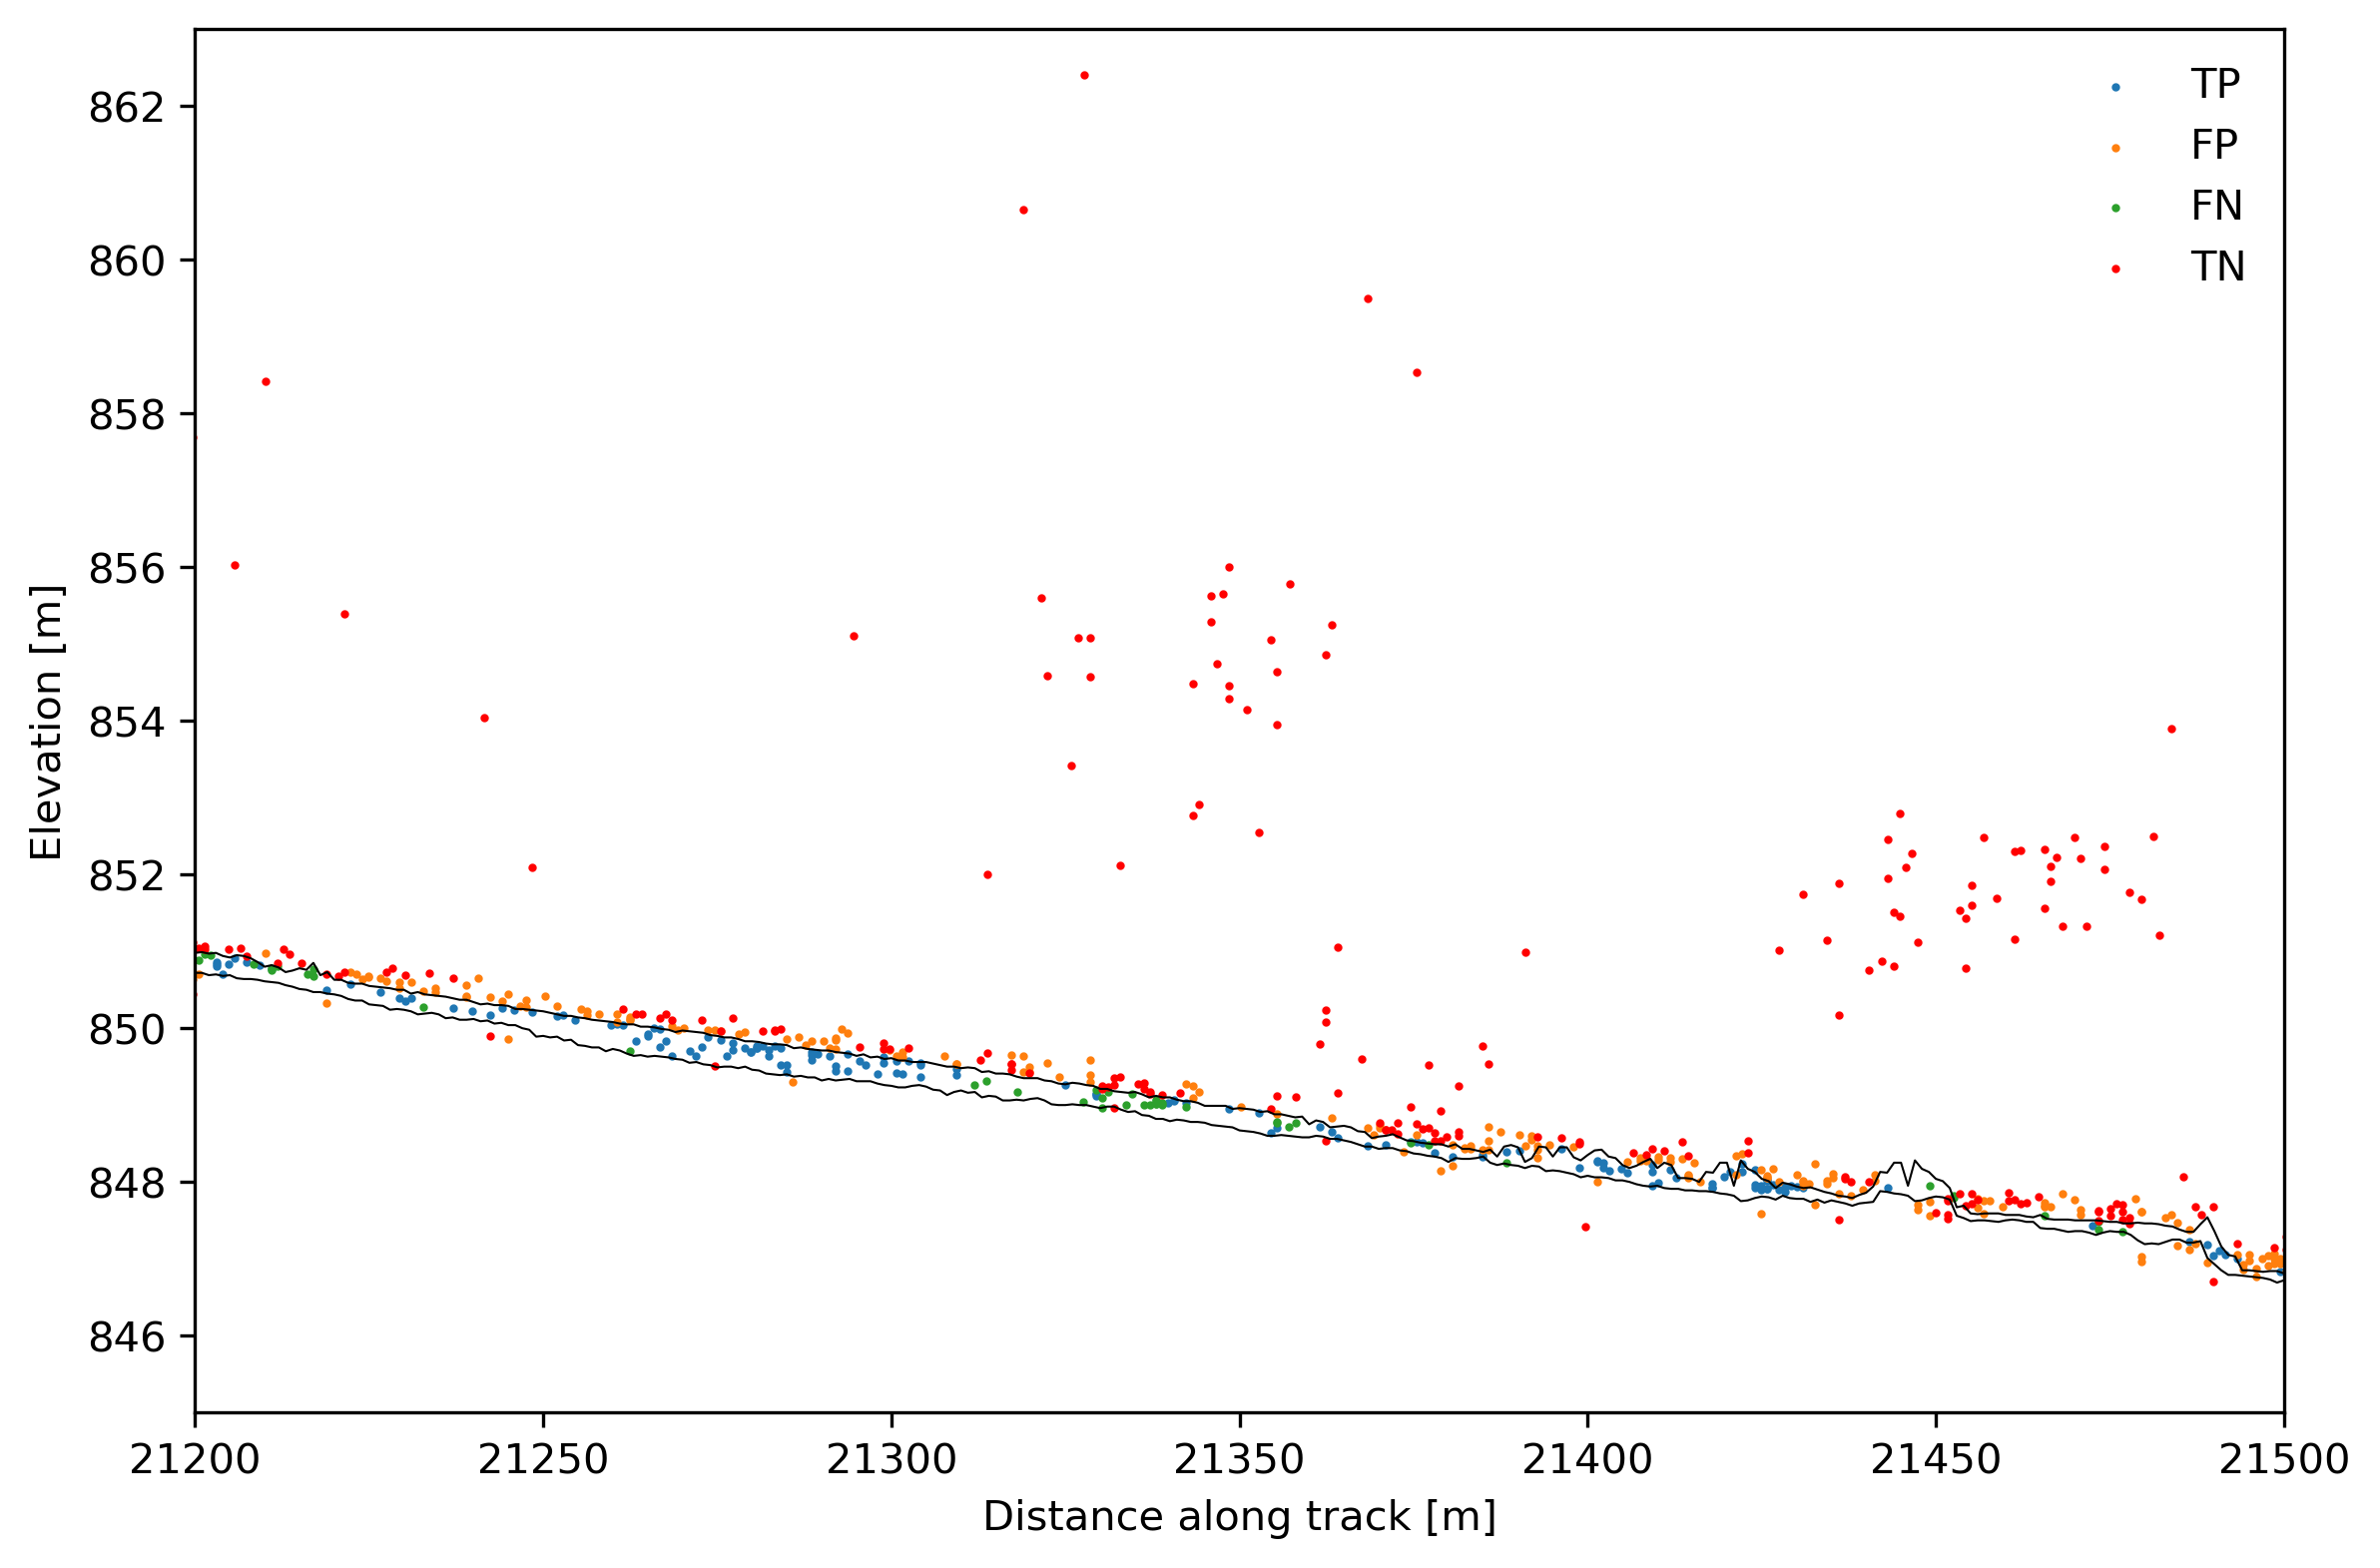

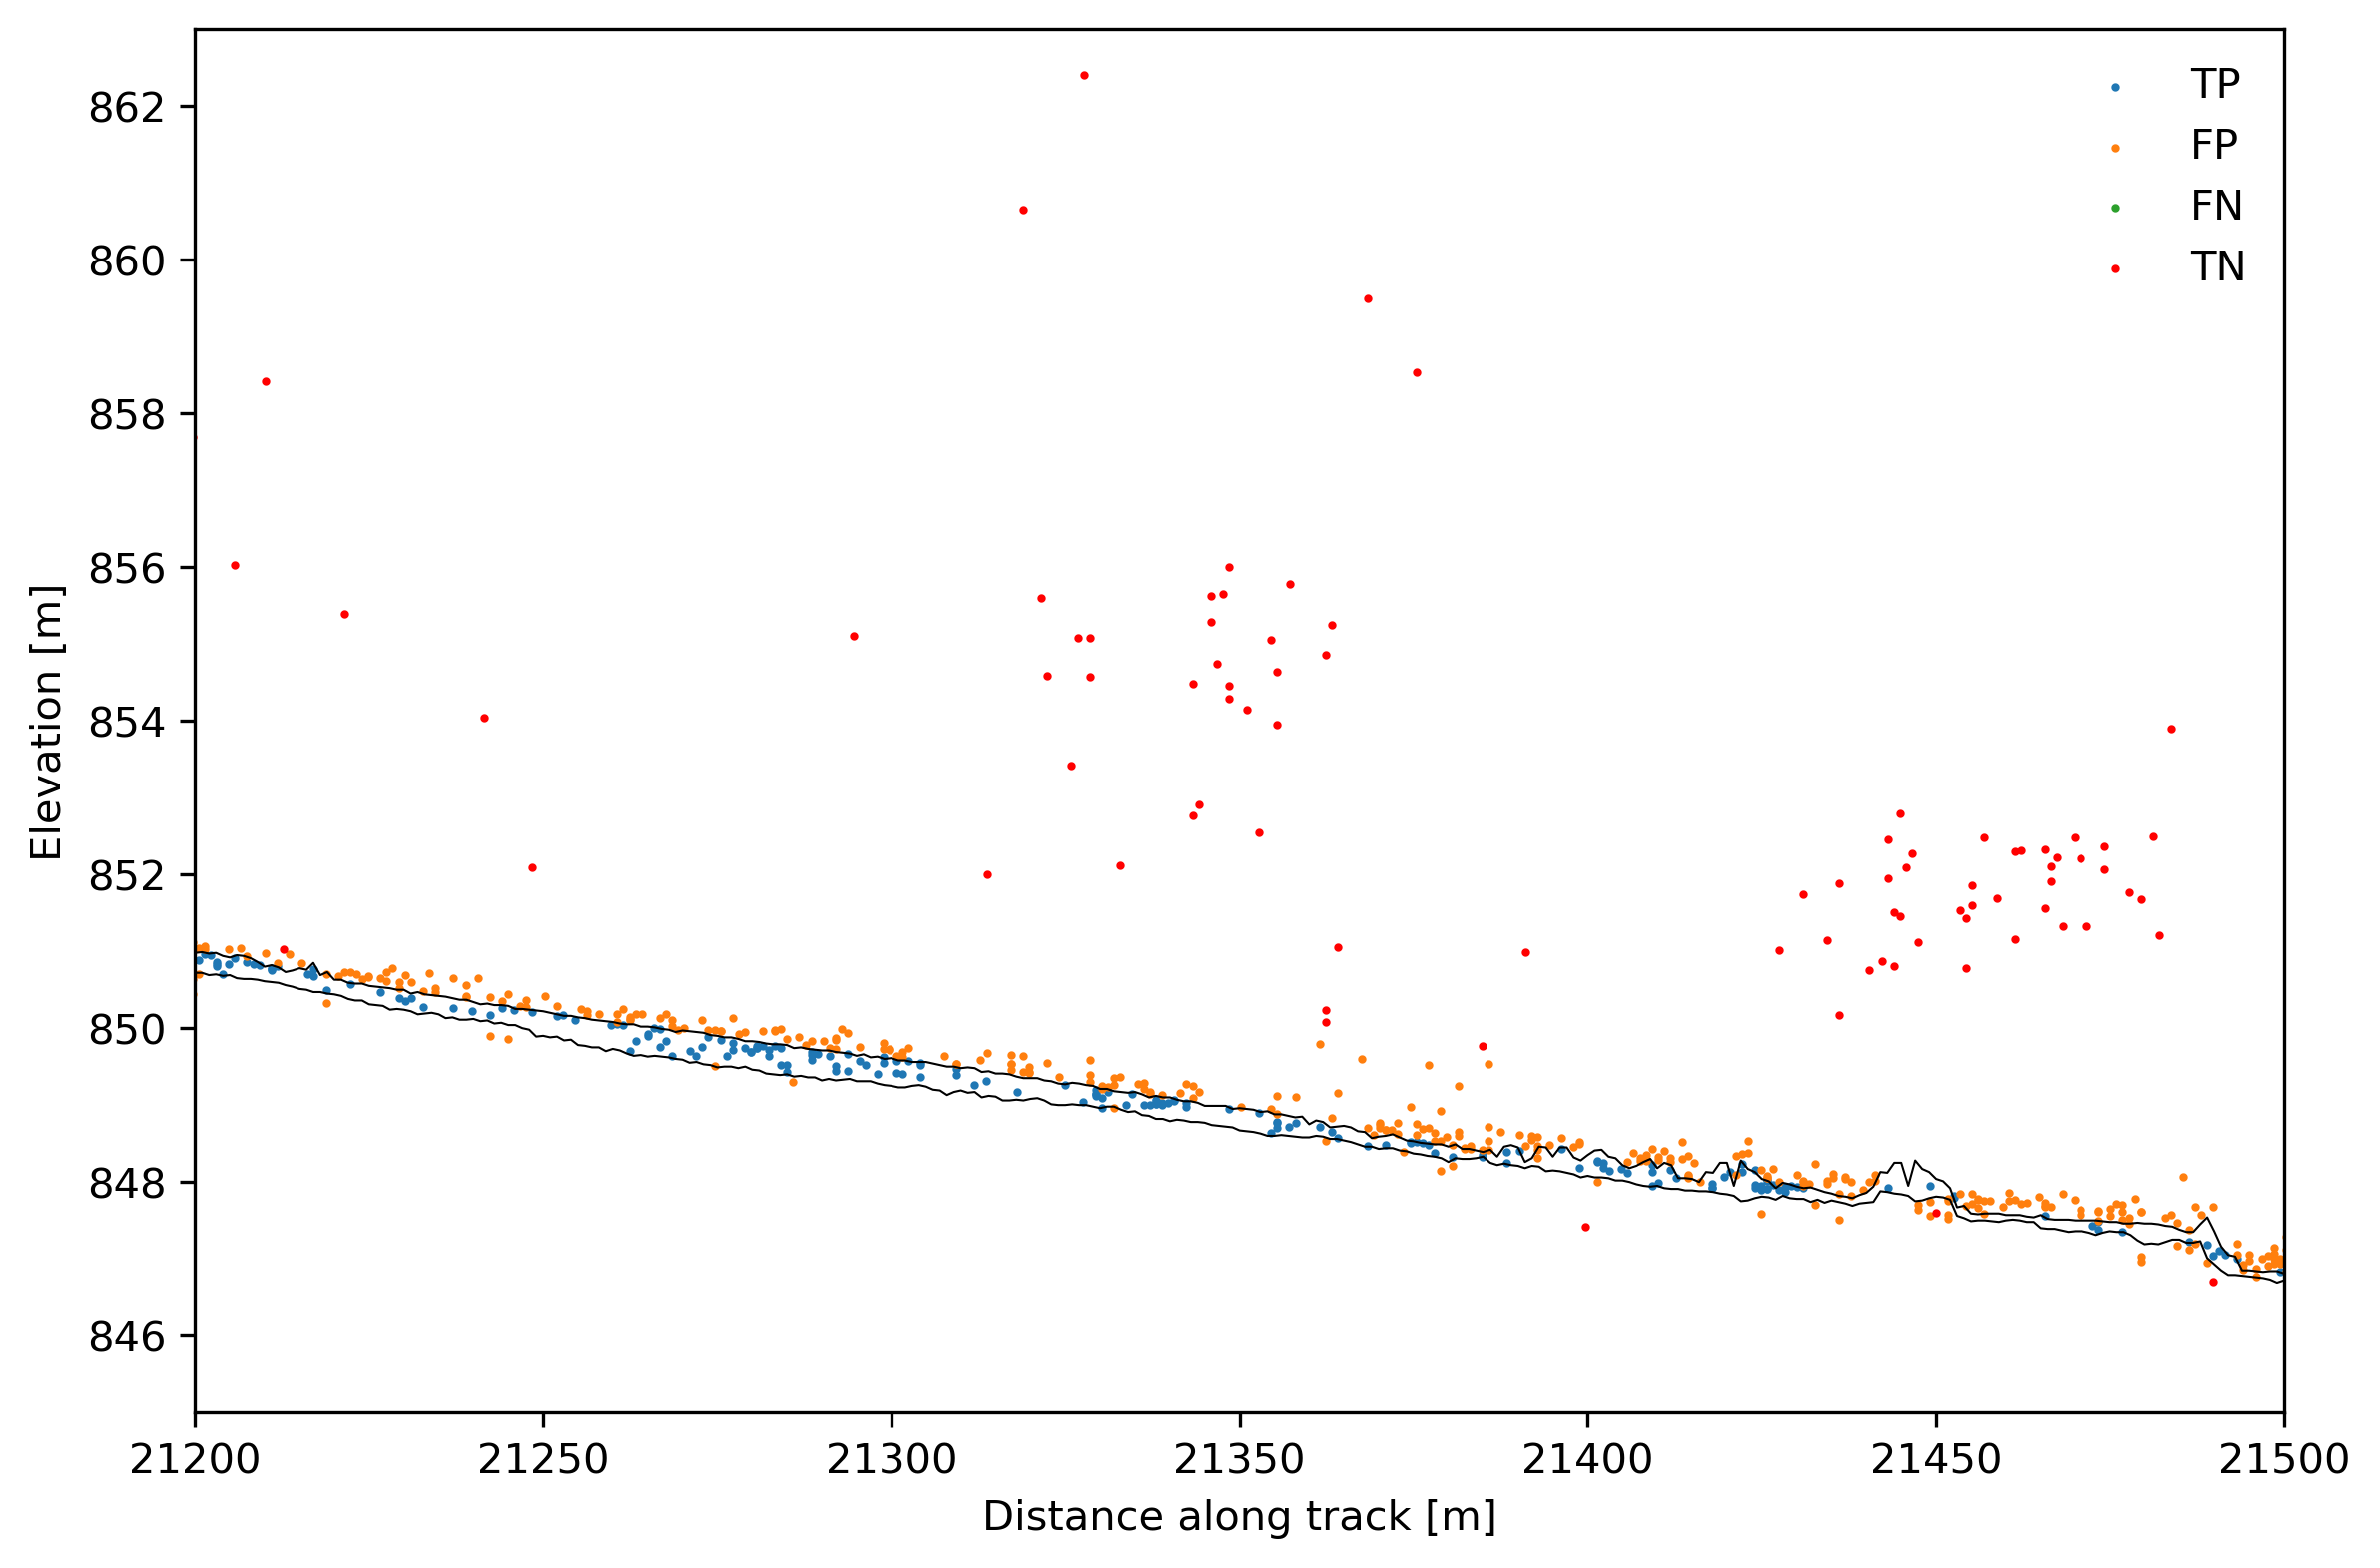

In [310]:
fig, ax = plt.subplots(figsize=(9,6))
fig.set_dpi(300)
ax.plot(max_min_envelope[:,0], c='k', lw=0.5)
ax.plot(max_min_envelope[:,1], c='k', lw=0.5)
ax.scatter(xz_icesat_PA[inside_PA,0], xz_icesat_PA[inside_PA,1], c='tab:blue', s=1, label='TP')
ax.scatter(xz_icesat_PA[outside_PA,0], xz_icesat_PA[outside_PA,1], c='tab:orange', s=1, label='FP')
ax.scatter(xz_icesat_nPA[inside_nPA,0], xz_icesat_nPA[inside_nPA,1], c='tab:green', s=1, label='FN')
ax.scatter(xz_icesat_nPA[outside_nPA,0], xz_icesat_nPA[outside_nPA,1], c='r', s=1, label='TN')
ax.legend(frameon=False)
ax.set_xlim(21200,21500);
ax.set_ylim(845,863);
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]')

plt.savefig('../writing/img/env_3.png', bbox_inches='tight', transparent=True)

fig, ax = plt.subplots(figsize=(9,6))
fig.set_dpi(300)
ax.plot(max_min_envelope[:,0], c='k', lw=0.5)
ax.plot(max_min_envelope[:,1], c='k', lw=0.5)
ax.scatter(xz_icesat_ML[inside_ML,0], xz_icesat_ML[inside_ML,1], c='tab:blue', s=1, label='TP')
ax.scatter(xz_icesat_ML[outside_ML,0], xz_icesat_ML[outside_ML,1], c='tab:orange', s=1, label='FP')
ax.scatter(xz_icesat_nML[inside_nML,0], xz_icesat_nML[inside_nML,1], c='tab:green', s=1, label='FN')
ax.scatter(xz_icesat_nML[outside_nML,0], xz_icesat_nML[outside_nML,1], c='r', s=1, label='TN')
ax.legend(frameon=False)
ax.set_xlim(21200,21500);
ax.set_ylim(845,863);
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]')

plt.savefig('../writing/img/env_4.png', bbox_inches='tight', transparent=True)

## distribution of ground

In [294]:
print(f'PA: Total of ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_PA[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat_PA[:,0] >= 15500)&(xz_icesat_PA[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat_PA[:,0] >= 20000)&(xz_icesat_PA[:,0] < 23250) | (xz_icesat_PA[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat_PA[:,0].shape[0]}\n')

print(f'PA: Percentage of ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_PA[:,0] < 15500)[0].shape[0] / np.where(xz_icesat[:,0] < 15500)[0].shape[0] * 100:.2f} %')
print(f'Foothills: {np.where((xz_icesat_PA[:,0] >= 15500)&(xz_icesat_PA[:,0] < 20000))[0].shape[0] / np.where((xz_icesat[:,0] >= 15500)&(xz_icesat[:,0] < 20000))[0].shape[0] * 100:.2f} %')
print(f'Plains: {np.where((xz_icesat_PA[:,0] >= 20000)&(xz_icesat_PA[:,0] < 23250) | (xz_icesat_PA[:,0] >= 23700))[0].shape[0] / np.where((xz_icesat[:,0] >= 20000)&(xz_icesat[:,0] < 23250) | (xz_icesat[:,0] >= 23700))[0].shape[0] * 100:.2f} %')
print(f'all: {xz_icesat_PA[:,0].shape[0] / xz_icesat[:,0].shape[0] * 100:.2f} %')

PA: Total of ground photons per landscape
Mountains: 30332
Foothills: 7343
Plains: 19691
all: 58237

PA: Percentage of ground photons per landscape
Mountains: 79.25 %
Foothills: 76.67 %
Plains: 77.10 %
all: 77.91 %


In [295]:
print(f'PA: Total of non-ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_nPA[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat_nPA[:,0] >= 15500)&(xz_icesat_nPA[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat_nPA[:,0] >= 20000)&(xz_icesat_nPA[:,0] < 23250) | (xz_icesat_nPA[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat_nPA[:,0].shape[0]}')

print(f'PA: Percentage of non-ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_nPA[:,0] < 15500)[0].shape[0] / np.where(xz_icesat[:,0] < 15500)[0].shape[0] * 100:.2f} %')
print(f'Foothills: {np.where((xz_icesat_nPA[:,0] >= 15500)&(xz_icesat_nPA[:,0] < 20000))[0].shape[0] / np.where((xz_icesat[:,0] >= 15500)&(xz_icesat[:,0] < 20000))[0].shape[0] * 100:.2f} %')
print(f'Plains: {np.where((xz_icesat_nPA[:,0] >= 20000)&(xz_icesat_nPA[:,0] < 23250) | (xz_icesat_nPA[:,0] >= 23700))[0].shape[0] / np.where((xz_icesat[:,0] >= 20000)&(xz_icesat[:,0] < 23250) | (xz_icesat[:,0] >= 23700))[0].shape[0] * 100:.2f} %')
print(f'all: {xz_icesat_nPA[:,0].shape[0] / xz_icesat[:,0].shape[0] * 100:.2f} %')

PA: Total of non-ground photons per landscape
Mountains: 7941
Foothills: 2235
Plains: 5849
all: 16512
PA: Percentage of non-ground photons per landscape
Mountains: 20.75 %
Foothills: 23.33 %
Plains: 22.90 %
all: 22.09 %


In [296]:
print(f'ML: Total of ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_ML[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat_ML[:,0] >= 15500)&(xz_icesat_ML[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat_ML[:,0] >= 20000)&(xz_icesat_ML[:,0] < 23250) | (xz_icesat_ML[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat_ML[:,0].shape[0]}\n')

print(f'ML: Percentage of ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_ML[:,0] < 15500)[0].shape[0] / np.where(xz_icesat[:,0] < 15500)[0].shape[0] * 100:.2f} %')
print(f'Foothills: {np.where((xz_icesat_ML[:,0] >= 15500)&(xz_icesat_ML[:,0] < 20000))[0].shape[0] / np.where((xz_icesat[:,0] >= 15500)&(xz_icesat[:,0] < 20000))[0].shape[0] * 100:.2f} %')
print(f'Plains: {np.where((xz_icesat_ML[:,0] >= 20000)&(xz_icesat_ML[:,0] < 23250) | (xz_icesat_ML[:,0] >= 23700))[0].shape[0] / np.where((xz_icesat[:,0] >= 20000)&(xz_icesat[:,0] < 23250) | (xz_icesat[:,0] >= 23700))[0].shape[0] * 100:.2f} %')
print(f'all: {xz_icesat_ML[:,0].shape[0] / xz_icesat[:,0].shape[0] * 100:.2f} %')

ML: Total of ground photons per landscape
Mountains: 29011
Foothills: 8847
Plains: 24377
all: 62235

ML: Percentage of ground photons per landscape
Mountains: 75.80 %
Foothills: 92.37 %
Plains: 95.45 %
all: 83.26 %


In [297]:
print(f'ML: Total of non-ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_nML[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat_nML[:,0] >= 15500)&(xz_icesat_nML[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat_nML[:,0] >= 20000)&(xz_icesat_nML[:,0] < 23250) | (xz_icesat_nML[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat_nML[:,0].shape[0]}\n')

print(f'ML: Percentage of non-ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_nML[:,0] < 15500)[0].shape[0] / np.where(xz_icesat[:,0] < 15500)[0].shape[0] * 100:.2f} %')
print(f'Foothills: {np.where((xz_icesat_nML[:,0] >= 15500)&(xz_icesat_nML[:,0] < 20000))[0].shape[0] / np.where((xz_icesat[:,0] >= 15500)&(xz_icesat[:,0] < 20000))[0].shape[0] * 100:.2f} %')
print(f'Plains: {np.where((xz_icesat_nML[:,0] >= 20000)&(xz_icesat_nML[:,0] < 23250) | (xz_icesat_nML[:,0] >= 23700))[0].shape[0] / np.where((xz_icesat[:,0] >= 20000)&(xz_icesat[:,0] < 23250) | (xz_icesat[:,0] >= 23700))[0].shape[0] * 100:.2f} %')
print(f'all: {xz_icesat_nML[:,0].shape[0] / xz_icesat[:,0].shape[0] * 100:.2f} %')

ML: Total of non-ground photons per landscape
Mountains: 9262
Foothills: 731
Plains: 1163
all: 12514

ML: Percentage of non-ground photons per landscape
Mountains: 24.20 %
Foothills: 7.63 %
Plains: 4.55 %
all: 16.74 %


In [299]:
print(f'Total of photons per landscape')
print(f'Mountains: {np.where(xz_icesat[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat[:,0] >= 15500)&(xz_icesat[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat[:,0] >= 20000)&(xz_icesat[:,0] < 23250) | (xz_icesat[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat[:,0].shape[0]}\n')

Total of photons per landscape
Mountains: 38273
Foothills: 9578
Plains: 25540
all: 74749



In [11]:
groundALS = np.load('../data/ground/ML/ground_06_new.npy')
xz_icesat_ground = xz_icesat[groundALS]

print(f'Total of ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_ground[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat_ground[:,0] >= 15500)&(xz_icesat_ground[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat_ground[:,0] >= 20000)&(xz_icesat_ground[:,0] < 23250) | (xz_icesat_ground[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat_ground[:,0].shape[0]}\n')

Total of ground photons per landscape
Mountains: 27461
Foothills: 8600
Plains: 24190
all: 60278



In [12]:
print(f'Total of ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_ground[:,0] < 15500)[0].shape[0]}')
print(f'Foothills: {np.where((xz_icesat_ground[:,0] >= 15500)&(xz_icesat_ground[:,0] < 20000))[0].shape[0]}')
print(f'Plains: {np.where((xz_icesat_ground[:,0] >= 20000)&(xz_icesat_ground[:,0] < 23250) | (xz_icesat_ground[:,0] >= 23700))[0].shape[0]}')
print(f'all: {xz_icesat_ground[:,0].shape[0]}\n')

print(f'ML: Percentage of non-ground photons per landscape')
print(f'Mountains: {np.where(xz_icesat_ground[:,0] < 15500)[0].shape[0] / np.where(xz_icesat[:,0] < 15500)[0].shape[0] * 100:.2f} %')
print(f'Foothills: {np.where((xz_icesat_ground[:,0] >= 15500)&(xz_icesat_ground[:,0] < 20000))[0].shape[0] / np.where((xz_icesat[:,0] >= 15500)&(xz_icesat[:,0] < 20000))[0].shape[0] * 100:.2f} %')
print(f'Plains: {np.where((xz_icesat_ground[:,0] >= 20000)&(xz_icesat_ground[:,0] < 23250) | (xz_icesat_ground[:,0] >= 23700))[0].shape[0] / np.where((xz_icesat[:,0] >= 20000)&(xz_icesat[:,0] < 23250) | (xz_icesat[:,0] >= 23700))[0].shape[0] * 100:.2f} %')
print(f'all: {xz_icesat_ground[:,0].shape[0] / xz_icesat[:,0].shape[0] * 100:.2f} %')

Total of ground photons per landscape
Mountains: 27461
Foothills: 8600
Plains: 24190
all: 60278

ML: Percentage of non-ground photons per landscape
Mountains: 71.75 %
Foothills: 89.79 %
Plains: 94.71 %
all: 80.64 %


## redo Figure 3.13

In [37]:
TP_indices = np.load('../data/ground/ML/TP_indices.npy')
TN_indices = np.load('../data/ground/ML/TN_indices.npy')
FP_indices = np.load('../data/ground/ML/FP_indices.npy')
FN_indices = np.load('../data/ground/ML/FN_indices.npy')

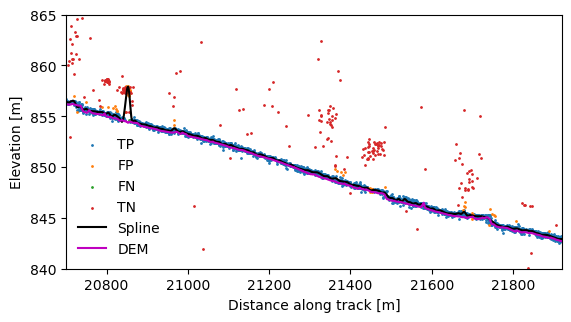

In [54]:
fig, ax = plt.subplots()
#fig.set_dpi(200)
#ax.scatter(xz_icesat[:,0],xz_icesat[:,1], c='k', s=1, label='ICESat-2 photons');
ax.scatter(xz_icesat[TP_indices,0],xz_icesat[TP_indices,1], c='tab:blue', s=1, label='TP');
ax.scatter(xz_icesat[FP_indices,0],xz_icesat[FP_indices,1], c='tab:orange', s=1, label='FP');
ax.scatter(xz_icesat[FN_indices,0],xz_icesat[FN_indices,1], c='tab:green', s=1, label='FN');
ax.scatter(xz_icesat[TN_indices,0],xz_icesat[TN_indices,1], c='tab:red', s=1, label='TN');

xz_icesat_ML = xz_icesat_ML[np.where(xz_icesat_ML[:,0] < 23250)[0]] 
t = np.arange(xz_icesat_ML[0,0]+1, xz_icesat_ML[-1,0]-1, 7).tolist()
spl = LSQUnivariateSpline(xz_icesat_ML[:,0], xz_icesat_ML[:,1], t)
ax.plot(xz_icesat_ML[:,0], spl(xz_icesat_ML[:,0]), label='Spline', c='k')

ax.plot(gdf.alongtrack_XYZ, gdf.dem_1m_nav, label='DEM', c='m')

ax.legend(frameon=False)
ax.set_xlim(20700,21920)
ax.set_ylim(840,865)
ax.set_aspect(25)
#ax.grid()
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]');
plt.savefig('../writing/img/ground_scene_unet.png', dpi=300, bbox_inches='tight', transparent=True)